#**AI in Industry**

**Author**: Jyoti Yadav

**Date**: March 2022

**Email**: jyoti.yadav@studio.unibo.it

##Preliminary Steps

In [1]:
# The libraries we will use are imported here, in case of runtime problems
import sys 
import gzip
import os, shutil  #  file management
import pandas as pd  #  dataframe management
import numpy as np  #  data manipulation
import seaborn as sns
from urllib import request
from keras import regularizers
import matplotlib.pyplot as plt
from sklearn import preprocessing
from keras.callbacks import EarlyStopping
from keras.models import Model, Sequential
from tensorflow.keras.utils import plot_model
from keras.layers import Input, Dense,Dropout
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import precision_score, recall_score,f1_score
from sklearn.metrics import precision_recall_curve, classification_report, confusion_matrix, average_precision_score, roc_curve, auc




LABELS = ["Normal","Anomly"]
random_state=2022

it is necessary, to clean all the data that are in the DATASETS directory and wipe out all the subdirectories.

In [2]:
folder = os.getcwd()

print("Current work directory: " + str(folder))
dataset_folder = os.path.join(os.getcwd(), "Datasets")

if not os.path.exists(dataset_folder):
    os.makedirs(dataset_folder)

for filename in os.listdir(dataset_folder):
    file_path = os.path.join(dataset_folder, filename)
    try:
        if os.path.isfile(file_path) or os.path.islink(file_path):
            os.unlink(file_path)
        elif os.path.isdir(file_path):
            shutil.rmtree(file_path)
    except Exception as e:
        print('Failed to delete %s. Reason: %s' % (file_path, e))

print("Cleaned")

Current work directory: /content
Cleaned


##Dataset Download

In [3]:
# Config
print("Current work directory: {}".format(os.getcwd()))
dataset_folder = os.path.join(os.getcwd(), "Datasets")

if not os.path.exists(dataset_folder):
    os.makedirs(dataset_folder)

url = "https://github.com/jyotiyadav94/Ai-in-industry/raw/main/new_data/r205n13.gzip"

dataset_path = os.path.join(dataset_folder, "r205n12.gzip")

print(dataset_path)

def download_dataset(download_path: str, url: str):
    if not os.path.exists(download_path):
        print("Downloading dataset...")
        request.urlretrieve(url, download_path)
        print("Download complete!")


def extract_dataset(download_path: str, extract_path: str):
    data = pd.read_parquet('/content/Datasets/r205n12.gzip')
    print("Extraction completed!")
    return data

# Download
download_dataset(dataset_path, url)

#Extraction
df=extract_dataset(dataset_path, dataset_folder)


Current work directory: /content
/content/Datasets/r205n12.gzip
Download complete!
Extraction completed!


In [4]:
df.head(5)

,timestamp,avg:ambient,var:ambient,max:ambient,min:ambient,avg:dimm0_temp,var:dimm0_temp,max:dimm0_temp,min:dimm0_temp,avg:dimm10_temp,...,avg:swap_free,var:swap_free,max:swap_free,min:swap_free,avg:swap_total,var:swap_total,max:swap_total,min:swap_total,label,New_label
index,,,,,,,,,,,,,,,,,,,,,
13218,2020-07-16 19:30:00,23.493333,0.067810,23.8,23.0,29.133333,0.123810,30,29,31.6,...,4194240.0,0.0,4194240,4194240,4194240,0.0,4194240,4194240,0,2
13221,2020-07-16 19:45:00,25.573333,0.027810,25.8,25.4,30.800000,0.171429,31,30,33.0,...,4194240.0,0.0,4194240,4194240,4194240,0.0,4194240,4194240,0,2
13278,2020-07-17 00:30:00,21.569231,0.018974,21.8,21.4,27.000000,0.000000,27,27,31.0,...,4194240.0,0.0,4194240,4194240,4194240,0.0,4194240,4194240,0,0
13281,2020-07-17 00:45:00,21.600000,0.022857,21.8,21.4,27.000000,0.000000,27,27,31.0,...,4194240.0,0.0,4194240,4194240,4194240,0.0,4194240,4194240,0,0
13284,2020-07-17 01:00:00,21.280000,0.021714,21.4,21.0,27.000000,0.000000,27,27,31.0,...,4194240.0,0.0,4194240,4194240,4194240,0.0,4194240,4194240,0,0


## Data Analysis

In [5]:
df.isnull().values.any()

False

In [6]:
missing_values = df.isnull().sum()
missing_per = (missing_values/df.shape[0])*100
missing_table = pd.concat([missing_values,missing_per], axis=1, ignore_index=True) 
missing_table.rename(columns={0:'Total Missing Values',1:'Missing %'}, inplace=True)
missing_table

,Total Missing Values,Missing %
timestamp,0,0.0
avg:ambient,0,0.0
var:ambient,0,0.0
max:ambient,0,0.0
min:ambient,0,0.0
...,...,...
var:swap_total,0,0.0
max:swap_total,0,0.0
min:swap_total,0,0.0
label,0,0.0


In [7]:
print("No. of unique labels ", len(df['New_label'].unique()))
print("Label values ",df.New_label.unique())

No. of unique labels  2
Label values  [2 0]


In [8]:
data = df['New_label'].value_counts().to_frame().reset_index()
data['percent'] = data["New_label"].apply(lambda x : round(100*float(x) / len(df), 2))
data = data.rename(columns = {"index" : "Target", "New_label" : "Count"})
data

,Target,Count,percent
0,0,9197,92.14
1,2,785,7.86


## Imabalanced dataset

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


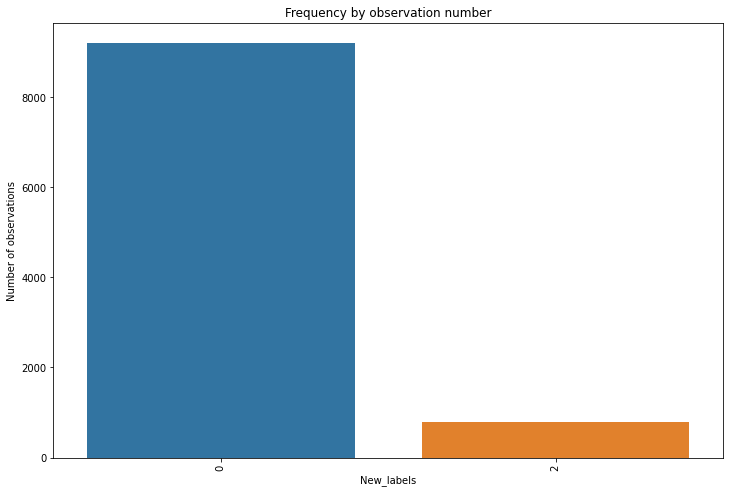

In [9]:
countSet = df['New_label'].value_counts()
countSet

plt.figure(figsize=(12,8))
sns.barplot(countSet.index,countSet.values,)
plt.ylabel('Number of observations')
plt.xlabel('New_labels')
plt.title('Frequency by observation number')
plt.xticks(rotation='vertical')
plt.show()

In [10]:
df.drop('label', axis=1, inplace=True)
df.drop('timestamp', axis=1, inplace=True)

##Train Test Split

In [11]:
X_train, X_test = train_test_split(df,test_size = 0.2,random_state=2022)

In [12]:
X_train=X_train[X_train.New_label==2]
X_train = X_train.drop(['New_label'], axis=1) 
y_test = X_test['New_label']
X_test = X_test.drop(['New_label'], axis=1)

##Minmax Scaling

In [13]:
normalizer = preprocessing.MinMaxScaler(feature_range=(0, 1))
normalized_train_X = pd.DataFrame(normalizer.fit_transform(X_train),  columns = X_train.columns)
normalized_test_X = pd.DataFrame(normalizer.fit_transform(X_test),  columns = X_test.columns)
normalized_test_y=normalizer.fit_transform(y_test.values.reshape(-1,1))
y_test_=normalized_test_y.ravel()

In [14]:
normalized_test_y

array([[0.],
       [0.],
       [0.],
       ...,
       [0.],
       [0.],
       [0.]])

## Autoencoder

In [15]:
input_dim=normalized_train_X.shape[1]
encoding_dim=30
hidden_dim_1 = int(encoding_dim / 2)
hidden_dim_2=4
epoch=100
batch_size=32
learning_rate = 1e-7

In [16]:
input_layer=Input(shape=(input_dim, ))
encoder=Dense(encoding_dim,activation='tanh',activity_regularizer=regularizers.l2(learning_rate))(input_layer)
encoder=Dropout(0.2)(encoder)
encoder=Dense(hidden_dim_1,activation='relu')(encoder)
encoder=Dropout(0.2)(encoder)
encoder=Dense(hidden_dim_2,activation='leaky_relu')(encoder)

decoder=Dense(hidden_dim_1,activation='relu')(encoder)
decoder=Dropout(0.2)(decoder)
decoder=Dense(encoding_dim,activation='relu')(decoder)
encoder=Dropout(0.2)(decoder)
decoder = Dense(input_dim, activation='tanh')(decoder)


autoencoder = Model(inputs=input_layer, outputs=decoder)
autoencoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 460)]             0         
                                                                 
 dense (Dense)               (None, 30)                13830     
                                                                 
 dropout (Dropout)           (None, 30)                0         
                                                                 
 dense_1 (Dense)             (None, 15)                465       
                                                                 
 dropout_1 (Dropout)         (None, 15)                0         
                                                                 
 dense_2 (Dense)             (None, 4)                 64        
                                                                 
 dense_3 (Dense)             (None, 15)                75    

In [17]:
#early stopping
early_stop=EarlyStopping(monitor='val_loss',min_delta=0.0001,patience=10,verbose=1,mode='min',restore_best_weights=True)
autoencoder.compile(loss='mean_squared_error',optimizer='adam')

#fit the model
history = autoencoder.fit(normalized_train_X, normalized_train_X, epochs=epoch, batch_size=batch_size,shuffle=True,validation_data=(normalized_test_X, normalized_test_X),verbose=1,callbacks=[early_stop]).history

Epoch 1/100
20/20 [==============================] - 3s 44ms/step - loss: 0.2652 - val_loss: 0.0922
Epoch 2/100
20/20 [==============================] - 1s 26ms/step - loss: 0.1054 - val_loss: 0.0952
Epoch 3/100
20/20 [==============================] - 0s 24ms/step - loss: 0.0517 - val_loss: 0.1140
Epoch 4/100
20/20 [==============================] - 1s 26ms/step - loss: 0.0427 - val_loss: 0.1063
Epoch 5/100
20/20 [==============================] - 0s 24ms/step - loss: 0.0370 - val_loss: 0.0810
Epoch 6/100
20/20 [==============================] - 0s 17ms/step - loss: 0.0331 - val_loss: 0.0723
Epoch 7/100
20/20 [==============================] - 0s 23ms/step - loss: 0.0293 - val_loss: 0.0615
Epoch 8/100
20/20 [==============================] - 0s 24ms/step - loss: 0.0288 - val_loss: 0.0674
Epoch 9/100
20/20 [==============================] - 0s 23ms/step - loss: 0.0270 - val_loss: 0.0675
Epoch 10/100
20/20 [==============================] - 0s 25ms/step - loss: 0.0261 - val_loss: 0.0621

In [18]:
autoencoder.save_weights('autoencoder.h5')

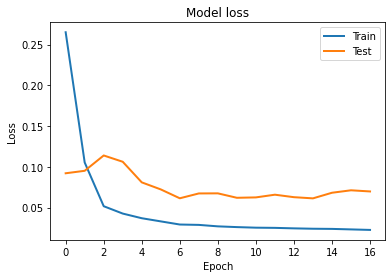

In [19]:
#plot the loss and validation loss of the model

plt.plot(history['loss'], linewidth=2, label='Train')
plt.plot(history['val_loss'], linewidth=2, label='Test')
plt.legend(loc='upper right')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

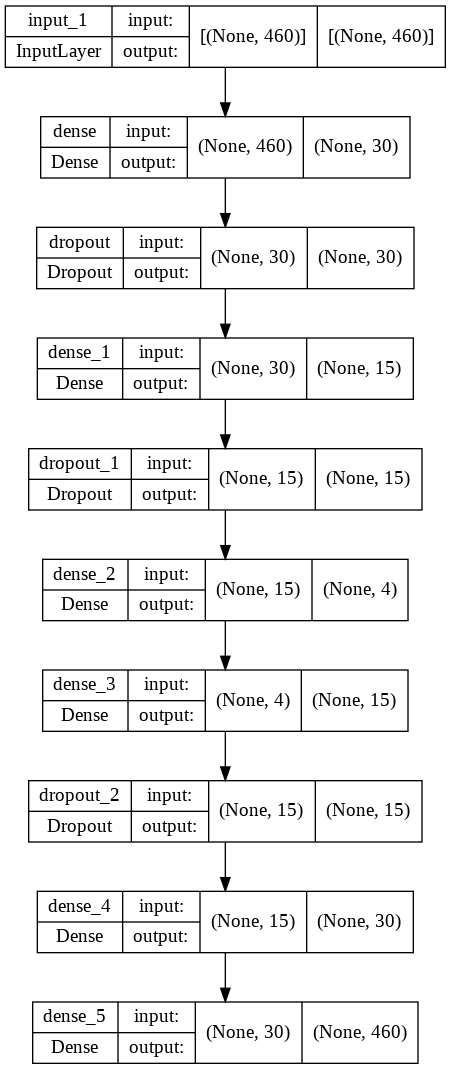

In [20]:
# plot the autoencoder
plot_model(autoencoder, 'autoencoder.png', show_shapes=True)

## Reconstruction error check

In [21]:
test_x_predictions=autoencoder.predict(normalized_test_X)
mse=np.mean(np.power(normalized_test_X-test_x_predictions,2),axis=1)

error=pd.DataFrame({'Reconstruction_error':mse,'True_class':y_test_})
error.describe()

,Reconstruction_error,True_class
count,1997.000000,1997.000000
mean,0.061472,0.072609
std,0.006511,0.259558
min,0.044817,0.000000
25%,0.058838,0.000000
50%,0.062595,0.000000
75%,0.064783,0.000000
max,0.131525,1.000000


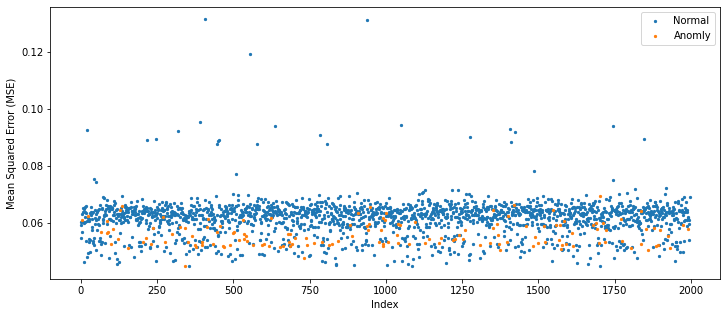

In [22]:
plt.figure(figsize=(12,5))
plt.scatter(error.index[error['True_class']==0],error[error['True_class']==0]['Reconstruction_error'],s=5,label='Normal')
plt.scatter(error.index[error['True_class']==1],error[error['True_class']==1]['Reconstruction_error'],s=5,label='Anomly')
plt.xlabel('Index')
plt.ylabel('Mean Squared Error (MSE)')
plt.legend()
plt.show()

In [23]:
# Plotting the precision recall curve.

precision,recall,threshold=precision_recall_curve(error.True_class,error.Reconstruction_error)
f1_score=2*precision*recall/(precision+recall)
average_precision=average_precision_score(error.True_class,error.Reconstruction_error)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in true_divide
  after removing the cwd from sys.path.


In [24]:
#choosing the threshold to maximize the F1 score

max_f1=f1_score[f1_score==max(f1_score)]
best_threshold=threshold[f1_score[1: ]==max_f1]
print('best threshold',best_threshold)

best threshold [0.05042756]


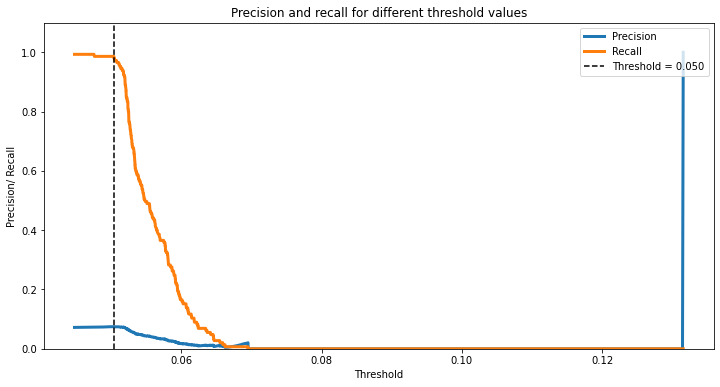

In [25]:
#Precision,Recall curve

plt.figure(figsize=(12,6))
plt.plot(threshold,precision[1: ],label='Precision',linewidth=3)
plt.plot(threshold, recall[1: ], label ="Recall", linewidth = 3)
plt.axvline(best_threshold, color = 'black', ls = '--', label = 'Threshold = %0.3f' % (best_threshold))
plt.ylim(0, 1.1)
plt.xlabel('Threshold')
plt.ylabel('Precision/ Recall')
plt.title('Precision and recall for different threshold values')
plt.legend(loc = 'upper right')

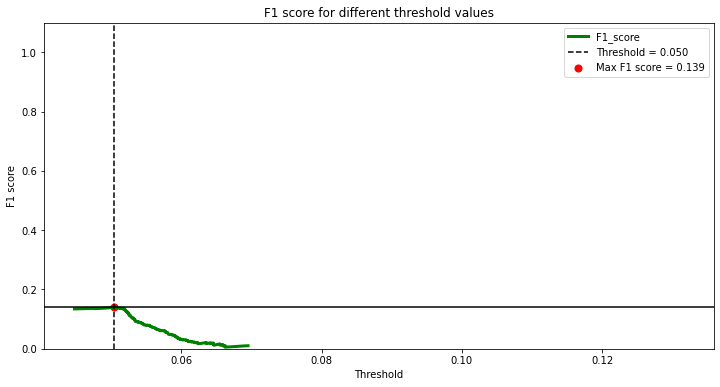

Best threshold = 0.050428
Max F1 score = 0.139376


In [26]:
#F1 score curve

plt.figure(figsize = (12, 6))
plt.plot(threshold, f1_score[1: ], label = "F1_score", linewidth = 3, color = 'green')
plt.scatter(threshold[f1_score[1: ] == max_f1], max_f1, label = 'Max F1 score = %0.3f' % (max_f1), s = 50, color = 'red')
plt.axvline(best_threshold, color = 'black', ls = '--', label = 'Threshold = %0.3f' % (best_threshold))
plt.axhline(max_f1, color = 'black', ls = '-')
plt.ylim(0, 1.1)
plt.xlabel('Threshold')
plt.ylabel('F1 score')
plt.title('F1 score for different threshold values')
plt.legend(loc = 'upper right')
plt.show()
print('Best threshold = %f' % (best_threshold))
print('Max F1 score = %f' % (max_f1))

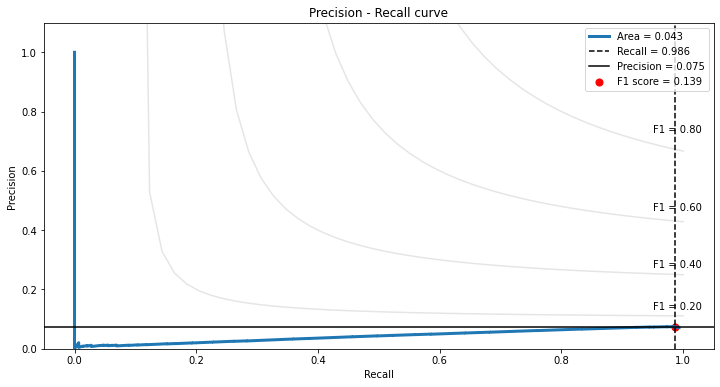

In [27]:
## Recall - Precision curve
plt.figure(figsize = (12, 6))
f_scores = np.linspace(0.2, 0.8, num = 4)

for f_score in f_scores:
    x = np.linspace(0.001, 1)
    y = f_score * x / (2 * x - f_score)
    plt.plot(x[y >= 0], y[y >= 0], color = 'gray', alpha = 0.2)
    plt.annotate('F1 = {0:0.2f}'.format(f_score), xy = (0.95, y[45] + 0.02))

plt.plot(recall[1: ], precision[1: ], label = 'Area = %0.3f' % (average_precision), linewidth = 3)
plt.scatter(recall[f1_score == max_f1], precision[f1_score == max_f1], label = 'F1 score = %0.3f' % (max_f1), s = 50, color = 'red')
plt.axvline(recall[f1_score == max_f1], color = 'black', ls = '--', label = 'Recall = %0.3f' % (recall[f1_score == max_f1]))
plt.axhline(precision[f1_score == max_f1], color = 'black', ls = '-', label = 'Precision = %0.3f' % (precision[f1_score == max_f1]))
plt.ylim(0, 1.1)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision - Recall curve')
plt.legend(loc = 'upper right')
plt.show()

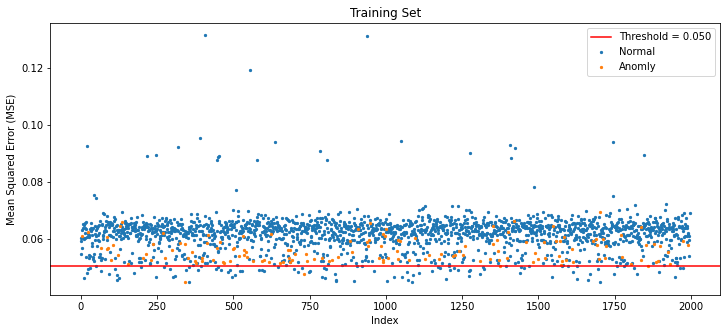

Best threshold = 0.050428


In [28]:
## Training Set

plt.figure(figsize = (12, 5))
plt.scatter(error.index[error['True_class'] == 0], error[error['True_class'] == 0]['Reconstruction_error'], s = 5, label = 'Normal')
plt.scatter(error.index[error['True_class'] == 1], error[error['True_class'] == 1]['Reconstruction_error'], s = 5, label = 'Anomly')
plt.axhline(best_threshold, color = 'red', label = 'Threshold = %0.3f' % (best_threshold))
plt.xlabel('Index')
plt.ylabel('Mean Squared Error (MSE)')
plt.title('Training Set')
plt.legend()
plt.show()
print('Best threshold = %f' % (best_threshold))

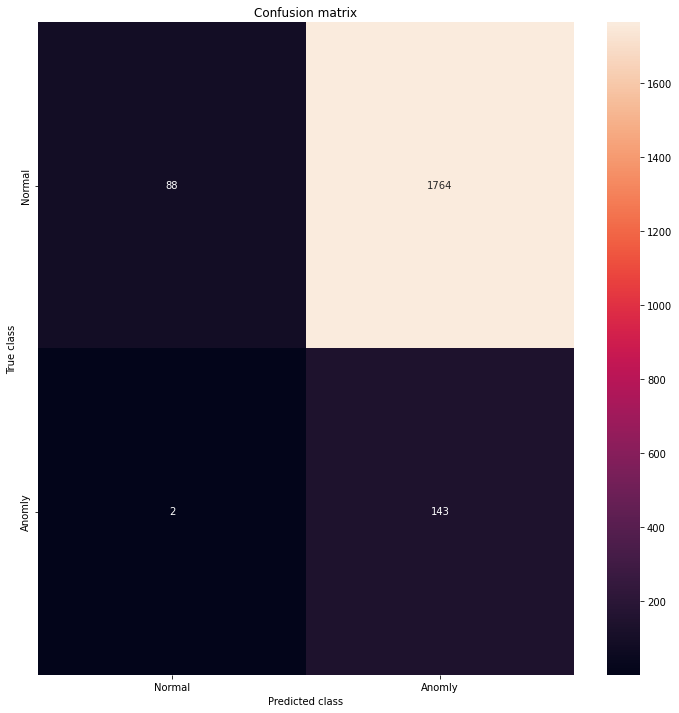

In [29]:
# if reconstruction error is greater than threshold it is Anomly 
pred_y = [1 if e > best_threshold  else 0 for e in error.Reconstruction_error.values]
error['pred'] =pred_y
conf_matrix = confusion_matrix(error.True_class, pred_y)
plt.figure(figsize=(12, 12))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

In [30]:
# print Accuracy, precision and recall

print(" Accuracy: ",accuracy_score(error['True_class'], error['pred']))
print(" Recall: ",recall_score(error['True_class'], error['pred']))
print(" Precision: ",precision_score(error['True_class'], error['pred']))

 Accuracy:  0.1156735102653981
 Recall:  0.9862068965517241
 Precision:  0.07498689040377557


In [31]:
print(classification_report(y_test_,pred_y))

              precision    recall  f1-score   support

         0.0       0.98      0.05      0.09      1852
         1.0       0.07      0.99      0.14       145

    accuracy                           0.12      1997
   macro avg       0.53      0.52      0.12      1997
weighted avg       0.91      0.12      0.09      1997

